In [8]:
import argparse
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('image', cmap='gray')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler
import os

In [9]:
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--validation-percentage', type=float, default=15., metavar='P',
                   help='percentage of training data used for validation')
parser.add_argument('--training-division', type=float, default=1., metavar='D',
                   help='divide the remaining training data by this factor')
parser.add_argument('--epochs', type=int, default=14, metavar='N',
                    help='number of epochs to train (default: 14)')
parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                    help='learning rate (default: 1.0)')
parser.add_argument('--step', type=int, default=1, metavar='N',
                    help='number of epochs between learning rate reductions (default: 1)')
parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                    help='Learning rate step gamma (default: 0.7)')
parser.add_argument('--no-cuda', action='store_true',
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-numbers', type=int, default=10, metavar='N',
                    help='how many entries of logging training status to show per epoch')
parser.add_argument('--evaluate', action='store_true',
                    help='evaluate your model on the official test set')
parser.add_argument('--load-model', type=str,
                    help='model file path')
parser.add_argument('--save-model', type=str,
                    help='For Saving the current Model');

args = parser.parse_args('--batch-size 256 --epochs 12 --lr 1 --step 1 --gamma 0.8 --seed 2020 --log-numbers 4'.split())

In [10]:
use_cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
path_outputs = '../data/hw03_outputs'

In [11]:
# Pytorch has default MNIST dataloader which loads data at each iteration
train_dataset = datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([       # Data preprocessing
        transforms.ToTensor(),           # Add data augmentation here
        transforms.Normalize((0.1307,), (0.3081,))
    ]))

train_labels = np.array([data[1] for data in train_dataset])
labels = np.unique(train_labels)

rng = np.random.default_rng(args.seed)
train_label_idc = [rng.permutation(np.argwhere(train_labels==l)) for l in labels]

subset_indices_train = [idx[0] for idc in train_label_idc for idx in idc[:np.round(len(idc)*(1-args.validation_percentage/100)).astype(int)]]
subset_indices_valid = [idx[0] for idc in train_label_idc for idx in idc[np.round(len(idc)*(1-args.validation_percentage/100)).astype(int):]]

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=args.batch_size,
    sampler=SubsetRandomSampler(subset_indices_train), **kwargs
)
val_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=args.batch_size,
    sampler=SubsetRandomSampler(subset_indices_valid), **kwargs
)

print(f'Loaded {len(train_dataset)} samples and divided into {len(train_loader.sampler)} training and {len(val_loader.sampler)} validation samples')

Loaded 60000 samples and divided into 51000 training and 9000 validation samples


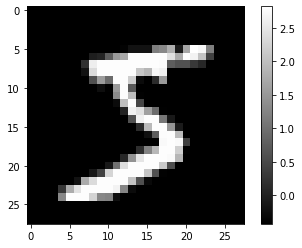

5
-0.42421296


In [12]:
plt.imshow(train_dataset[0][0].numpy().squeeze())
plt.colorbar()
plt.show()
print(train_dataset[0][1])
print(train_dataset[0][0].numpy().min())

In [13]:
def train(args, model, device, train_loader, optimizer, epoch, verbose=True):
    '''
    This is your training function. When you call this function, the model is
    trained for 1 epoch.
    '''
    model.train()   # Set the model to training mode
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()               # Clear the gradient
        output = model(data)                # Make predictions
        loss = F.nll_loss(output, target)   # Compute loss
        loss.backward()                     # Gradient computation
        optimizer.step()                    # Perform a single optimization step
        if batch_idx % (len(train_loader)//args.log_numbers) == 0 and verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader, name='Test', verbose=True):
    model.eval()    # Set the model to inference mode
    test_loss = 0.
    correct = 0.
    with torch.no_grad():   # For the inference step, gradient is not computed
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.sampler)
    
    if verbose:
        print('{:s} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            name, test_loss, correct, len(test_loader.sampler),
            100. * correct / len(test_loader.sampler)))
    
    return test_loss, correct


In [7]:
class ConvNet(nn.Module):
    '''
    Design your model with convolutional layers.
    '''
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, 1)
        self.conv2 = nn.Conv2d(8, 8, 3, 1)
        self.dropout1 = nn.Dropout2d(0.5)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(200, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout2(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        output = F.log_softmax(x, dim=1)
        return output

In [8]:
# Load your model [fcNet, ConvNet, Net]
model = ConvNet().to(device)

# Try different optimzers here [Adam, SGD, RMSprop]
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=args.step, gamma=args.gamma)

# Training loop
train_loss = np.zeros((args.epochs,))
val_loss = np.zeros((args.epochs,))
train_correct = np.zeros((args.epochs,))
val_correct = np.zeros((args.epochs,))
for epoch in range(args.epochs):
    train(args, model, device, train_loader, optimizer, epoch, verbose=False)
    train_loss[epoch], train_correct[epoch] = test(model, device, train_loader, name='Training')
    val_loss[epoch], val_correct[epoch] = test(model, device, val_loader, name='Validation')
    print()
    scheduler.step()    # learning rate scheduler

Training set: Average loss: 0.2924, Accuracy: 46278.0/51000 (91%)
Validation set: Average loss: 0.2907, Accuracy: 8160.0/9000 (91%)

Training set: Average loss: 0.2287, Accuracy: 47494.0/51000 (93%)
Validation set: Average loss: 0.2279, Accuracy: 8402.0/9000 (93%)

Training set: Average loss: 0.1208, Accuracy: 49044.0/51000 (96%)
Validation set: Average loss: 0.1282, Accuracy: 8651.0/9000 (96%)

Training set: Average loss: 0.0983, Accuracy: 49466.0/51000 (97%)
Validation set: Average loss: 0.1069, Accuracy: 8712.0/9000 (97%)

Training set: Average loss: 0.0978, Accuracy: 49499.0/51000 (97%)
Validation set: Average loss: 0.1080, Accuracy: 8710.0/9000 (97%)

Training set: Average loss: 0.0948, Accuracy: 49503.0/51000 (97%)
Validation set: Average loss: 0.1043, Accuracy: 8728.0/9000 (97%)

Training set: Average loss: 0.0838, Accuracy: 49709.0/51000 (97%)
Validation set: Average loss: 0.0951, Accuracy: 8752.0/9000 (97%)

Training set: Average loss: 0.0809, Accuracy: 49772.0/51000 (98%)
Val

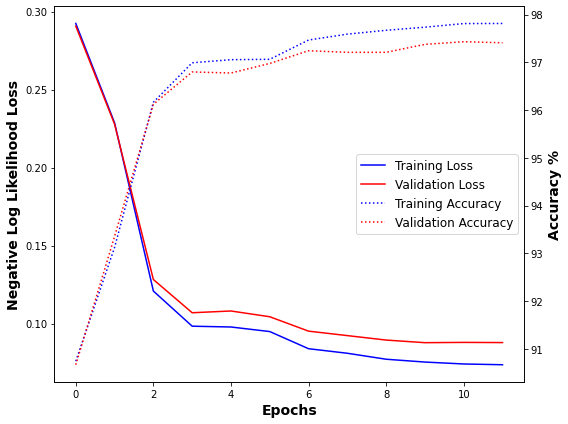

In [9]:
fig = plt.figure(figsize=(8, 6), tight_layout=True)
ax1 = plt.axes()
ax1.plot(np.arange(args.epochs), train_loss, 'b-', label='Training Loss')
ax1.plot(np.arange(args.epochs), val_loss, 'r-', label='Validation Loss')
ax1.set_xlabel('Epochs', fontsize=14, fontweight='bold')
ax1.set_ylabel('Negative Log Likelihood Loss', fontsize=14, fontweight='bold')
ax2 = ax1.twinx()
ax2.plot(np.arange(args.epochs), train_correct/len(train_loader.sampler)*100, 'b:', label='Training Accuracy')
ax2.plot(np.arange(args.epochs), val_correct/len(val_loader.sampler)*100, 'r:', label='Validation Accuracy')
# ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy %', fontsize=14, fontweight='bold')
lines1, line_labels1 = ax1.get_legend_handles_labels()
lines2, line_labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, line_labels1 + line_labels2, loc='right', fontsize=12)
plt.savefig(os.path.join(path_outputs, 'original_conv_no_aug.pdf'), pad_inches=0, bbox_inches='tight')
plt.show()

In [14]:
# Pytorch has default MNIST dataloader which loads data at each iteration
train_dataset_augmented = datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([       # Data preprocessing
        transforms.RandomAffine(4, translate=(.1, .1), scale=(.9, 1.1), shear=(2, 2, 2, 2)),
        transforms.ToTensor(),           # Add data augmentation here
        transforms.Normalize((0.1307,), (0.3081,))
    ]))

train_augmented_loader = torch.utils.data.DataLoader(
    train_dataset_augmented, batch_size=args.batch_size,
    sampler=SubsetRandomSampler(subset_indices_train), **kwargs
)

In [11]:
# Load your model [fcNet, ConvNet, Net]
model = ConvNet().to(device)

# Try different optimzers here [Adam, SGD, RMSprop]
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=args.step, gamma=1)

# Training loop
args.epochs = 18
train_loss = np.zeros((args.epochs,))
val_loss = np.zeros((args.epochs,))
train_correct = np.zeros((args.epochs,))
val_correct = np.zeros((args.epochs,))
for epoch in range(args.epochs):
    train(args, model, device, train_augmented_loader, optimizer, epoch, verbose=False)
    train_loss[epoch], train_correct[epoch] = test(model, device, train_loader, name='Training')
    val_loss[epoch], val_correct[epoch] = test(model, device, val_loader, name='Validation')
    print()
    scheduler.step()    # learning rate scheduler

Training set: Average loss: 0.3318, Accuracy: 45965.0/51000 (90%)
Validation set: Average loss: 0.3425, Accuracy: 8068.0/9000 (90%)

Training set: Average loss: 0.2325, Accuracy: 47200.0/51000 (93%)
Validation set: Average loss: 0.2418, Accuracy: 8328.0/9000 (93%)

Training set: Average loss: 0.1612, Accuracy: 48634.0/51000 (95%)
Validation set: Average loss: 0.1691, Accuracy: 8560.0/9000 (95%)

Training set: Average loss: 0.1491, Accuracy: 48757.0/51000 (96%)
Validation set: Average loss: 0.1600, Accuracy: 8591.0/9000 (95%)

Training set: Average loss: 0.1381, Accuracy: 48892.0/51000 (96%)
Validation set: Average loss: 0.1491, Accuracy: 8620.0/9000 (96%)

Training set: Average loss: 0.1197, Accuracy: 49219.0/51000 (97%)
Validation set: Average loss: 0.1283, Accuracy: 8681.0/9000 (96%)

Training set: Average loss: 0.1324, Accuracy: 48954.0/51000 (96%)
Validation set: Average loss: 0.1374, Accuracy: 8643.0/9000 (96%)

Training set: Average loss: 0.1148, Accuracy: 49239.0/51000 (97%)
Val

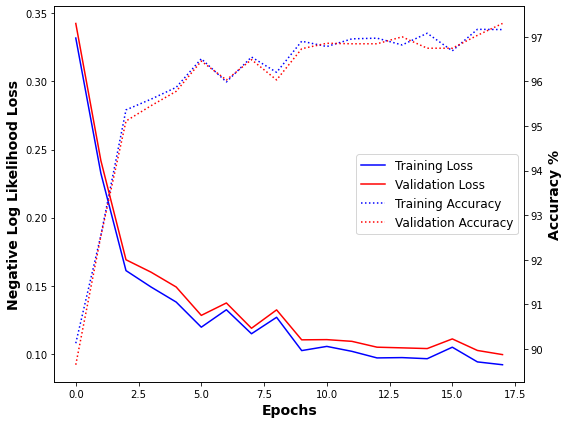

In [12]:
fig = plt.figure(figsize=(8, 6), tight_layout=True)
ax1 = plt.axes()
ax1.plot(np.arange(args.epochs), train_loss, 'b-', label='Training Loss')
ax1.plot(np.arange(args.epochs), val_loss, 'r-', label='Validation Loss')
ax1.set_xlabel('Epochs', fontsize=14, fontweight='bold')
ax1.set_ylabel('Negative Log Likelihood Loss', fontsize=14, fontweight='bold')
ax2 = ax1.twinx()
ax2.plot(np.arange(args.epochs), train_correct/len(train_loader.sampler)*100, 'b:', label='Training Accuracy')
ax2.plot(np.arange(args.epochs), val_correct/len(val_loader.sampler)*100, 'r:', label='Validation Accuracy')
# ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy %', fontsize=14, fontweight='bold')
lines1, line_labels1 = ax1.get_legend_handles_labels()
lines2, line_labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, line_labels1 + line_labels2, loc='right', fontsize=12)
plt.savefig(os.path.join(path_outputs, 'original_conv.pdf'), pad_inches=0, bbox_inches='tight')
plt.show()

In [13]:
torch.save(model.state_dict(), os.path.join(path_outputs, 'original_conv.pt'))

In [15]:
class Net(nn.Module):
    '''
    Build the best MNIST classifier.
    '''
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2, padding_mode='replicate')
        self.conv2 = nn.Conv2d(16, 24, kernel_size=3, stride=1, padding=1, padding_mode='replicate')
        self.batchNorm1 = nn.BatchNorm2d(16)
        self.batchNorm2 = nn.BatchNorm2d(24)
        self.dropout2d1 = nn.Dropout2d(0.6)
        self.dropout2d2 = nn.Dropout2d(0.6)
        self.fc1 = nn.Linear(1176, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout1 = nn.Dropout(0.9)
        self.dropout2 = nn.Dropout(0.8)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchNorm1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout2d1(x)

        x = self.conv2(x)
        x = self.batchNorm2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout2d2(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        #x = self.dropout1(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)

        output = F.log_softmax(x, dim=1)
        return output

In [16]:
x = torch.ones([1, 1, 28, 28], dtype=torch.float32)
print(Net().forward(x))

tensor([[-2.1770, -2.3699, -2.0855, -1.9367, -2.9724, -2.3707, -2.2666, -2.6157,
         -2.4194, -2.1684]], grad_fn=<LogSoftmaxBackward>)


In [16]:
# Load your model [fcNet, ConvNet, Net]
model = Net().to(device)

# Try different optimzers here [Adam, SGD, RMSprop]
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=args.step, gamma=1)

# Training loop
args.epochs = 16
train_loss = np.zeros((args.epochs,))
val_loss = np.zeros((args.epochs,))
train_correct = np.zeros((args.epochs,))
val_correct = np.zeros((args.epochs,))
for epoch in range(args.epochs):
    train(args, model, device, train_augmented_loader, optimizer, epoch, verbose=True)
    train_loss[epoch], train_correct[epoch] = test(model, device, train_loader, name='Training')
    val_loss[epoch], val_correct[epoch] = test(model, device, val_loader, name='Validation')
    print()
    scheduler.step()    # learning rate scheduler

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.333621
Train Epoch: 1 [12800/60000 (25%)]	Loss: 1.922833
Train Epoch: 1 [25600/60000 (50%)]	Loss: 1.718076
Train Epoch: 1 [38400/60000 (75%)]	Loss: 1.248799
Training set: Average loss: 0.4797, Accuracy: 45268.0/51000 (89%)
Validation set: Average loss: 0.4952, Accuracy: 7934.0/9000 (88%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.338912
Train Epoch: 2 [12800/60000 (25%)]	Loss: 1.064244
Train Epoch: 2 [25600/60000 (50%)]	Loss: 0.988080
Train Epoch: 2 [38400/60000 (75%)]	Loss: 0.915593
Training set: Average loss: 0.2274, Accuracy: 48013.0/51000 (94%)
Validation set: Average loss: 0.2369, Accuracy: 8472.0/9000 (94%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.782919
Train Epoch: 3 [12800/60000 (25%)]	Loss: 0.725655
Train Epoch: 3 [25600/60000 (50%)]	Loss: 0.690856
Train Epoch: 3 [38400/60000 (75%)]	Loss: 0.737063
Training set: Average loss: 0.1650, Accuracy: 48673.0/51000 (95%)
Validation set: Average loss: 0.1753, Accuracy: 8584.0/9000 (95%)

Train Epoch: 4 [

In [17]:
torch.save(model.state_dict(), os.path.join(path_outputs, 'best_conv.pt'))

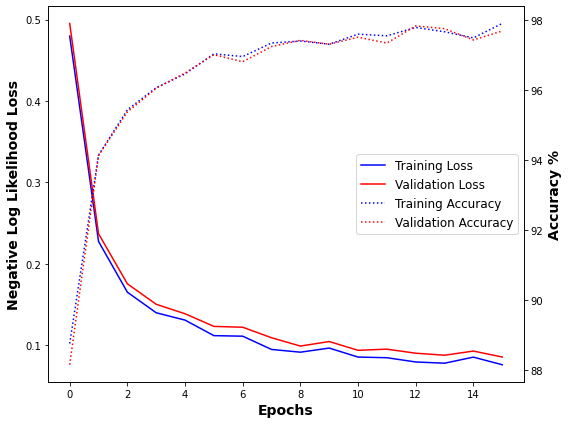

In [18]:
fig = plt.figure(figsize=(8, 6), tight_layout=True)
ax1 = plt.axes()
ax1.plot(np.arange(args.epochs), train_loss, 'b-', label='Training Loss')
ax1.plot(np.arange(args.epochs), val_loss, 'r-', label='Validation Loss')
ax1.set_xlabel('Epochs', fontsize=14, fontweight='bold')
ax1.set_ylabel('Negative Log Likelihood Loss', fontsize=14, fontweight='bold')
ax2 = ax1.twinx()
ax2.plot(np.arange(args.epochs), train_correct/len(train_loader.sampler)*100, 'b:', label='Training Accuracy')
ax2.plot(np.arange(args.epochs), val_correct/len(val_loader.sampler)*100, 'r:', label='Validation Accuracy')
# ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy %', fontsize=14, fontweight='bold')
lines1, line_labels1 = ax1.get_legend_handles_labels()
lines2, line_labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, line_labels1 + line_labels2, loc='right', fontsize=12)
plt.savefig(os.path.join(path_outputs, 'best_conv.pdf'), pad_inches=0, bbox_inches='tight')
plt.show()

In [18]:
test_dataset = datasets.MNIST('../data', train=False,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ]))

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=args.test_batch_size, shuffle=True, **kwargs)

test(model, device, test_loader);

Test set: Average loss: 0.0662, Accuracy: 9803.0/10000 (98%)


In [17]:
model = Net().to(device)
model.load_state_dict(torch.load(os.path.join(path_outputs, 'best_conv.pt')))

<All keys matched successfully>

In [19]:
model.eval() 

Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv2): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (batchNorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchNorm2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2d1): Dropout2d(p=0.6, inplace=False)
  (dropout2d2): Dropout2d(p=0.6, inplace=False)
  (fc1): Linear(in_features=1176, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout1): Dropout(p=0.9, inplace=False)
  (dropout2): Dropout(p=0.8, inplace=False)
)

In [27]:
data, target = next(iter(test_loader))
data, target = data.to(device), target.to(device)
output = model(data)
pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability


In [28]:
pred.size()

torch.Size([1000, 1])

In [31]:
model.eval()    # Set the model to inference mode
test_loss = 0.
correct = 0.
preds = np.zeros((0,), dtype=np.int)
with torch.no_grad():   # For the inference step, gradient is not computed
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        preds = np.hstack((preds, pred.cpu().numpy().flatten()))
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.sampler)


In [32]:
preds.shape

(10000,)